>---                                                                                                                                          
> ## 1. Introduction and Dataset Overview
>
> **Pourpose:** Use the Regression model to predict total energy production based on weather and weather variables.
>
> **Features:** 
date
Total Production (Wh)    
Total Consumption(Wh)    
speed                    
dir                      
drybulb                  
cbl                      
soltot                   
rain                     
>
> **Target:** Total Production (Wh)
>
> **Data format:** CSV
>
> **Data collection:** The data was acquired using directly from the StoreNet project (File names are modified according to the battery number. It has 3 folders inside it: energy, power and weather. Energy folder contains all energy data (Wh) and power folder contains all power data (W). For e.g. filename “90956_2020_Wh” means, energy data for battery ID 90956 for year 2020. Weather data was added additionally downloaded from https://www.met.ie/climate/available-data/historical-data) and processed in one file for whole year.
>
>
> **Direct URL to data:** https://www.nature.com/articles/s41597-024-03454-2/tables/7
>
>---

In [276]:
# Libraries
import pandas as pd
import numpy as np
import os # Library for interacting with the operating system

# Visualizations
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.ticker import FuncFormatter

# Statistic
import scipy.stats as stats

# Machine Learning
from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit  
from sklearn.model_selection import train_test_split 
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor
from scipy.stats import randint
from sklearn.metrics import (
    r2_score,
    mean_absolute_error,
    mean_squared_error
)

## 1. Loading Data

In [ ]:
# load datasets
energy_df = pd.read_csv('./dataset/energy_ie_clean.csv', parse_dates=['date'])
weather_df = pd.read_csv('.dataset/weather_ie_clean.csv', parse_dates=['date'])    

/var/folders/xj/vmtsvzgs6zj1l876xt4q0nkw0000gn/T/ipykernel_83995/3316301462.py:3: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  weather_df = pd.read_csv('./Classification Model/dataset/weather_ie_clean.csv', parse_dates=['date'])


In [278]:
combined_df = pd.merge(energy_df, weather_df, on='date', how='inner')

## 2. Data Preprocessing and Cleaning

### 2.1 Initial Exploration

In [279]:
# showing general information about the dataset
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207299 entries, 0 to 207298
Data columns (total 9 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   date                   207299 non-null  datetime64[ns]
 1   Total Production (Wh)  207299 non-null  float64       
 2   Total Consumption(Wh)  207299 non-null  float64       
 3   speed                  207299 non-null  float64       
 4   dir                    207299 non-null  float64       
 5   drybulb                207299 non-null  float64       
 6   cbl                    207299 non-null  float64       
 7   soltot                 207299 non-null  float64       
 8   rain                   207299 non-null  object        
dtypes: datetime64[ns](1), float64(7), object(1)
memory usage: 14.2+ MB


In [280]:
# showing general information about first 4 rows of dataset
combined_df.head()

,date,Total Production (Wh),Total Consumption(Wh),speed,dir,drybulb,cbl,soltot,rain
0,2020-01-01 01:01:00,0.00,99.55,2.970,158.5,8.64,1024.852,0.0,0
1,2020-01-01 01:02:00,0.22,101.75,2.483,160.7,8.65,1024.825,0.0,0
2,2020-01-01 01:03:00,0.52,122.98,2.582,149.1,8.66,1024.792,0.0,0
3,2020-01-01 01:04:00,0.08,160.05,2.989,146.0,8.67,1024.755,0.0,0
4,2020-01-01 01:05:00,0.23,172.83,3.466,145.0,8.69,1024.725,0.0,0


In [281]:
combined_df.columns.duplicated()

array([False, False, False, False, False, False, False, False, False])

In [282]:
combined_df['rain'].unique()
combined_df['rain'].value_counts(dropna=False)

rain
0.0    151970
0       50209
0.1      3152
0.1      1206
0.2       351
0.2       303
0.3        46
           18
0.3        10
0.4         9
0.4         7
0.5         4
0.8         3
0.8         3
0.6         2
0.6         2
0.7         1
0.5         1
1.8         1
1.4         1
Name: count, dtype: int64

In [283]:
combined_df['soltot'].unique()
combined_df['soltot'].value_counts(dropna=False)

soltot
0.000    101417
0.001       313
0.003       285
0.006       267
0.004       253
          ...  
5.474         1
6.394         1
5.927         1
5.183         1
5.556         1
Name: count, Length: 6216, dtype: int64

In [284]:
combined_df['soltot'].unique()
combined_df['soltot'].value_counts(dropna=False)

soltot
0.000    101417
0.001       313
0.003       285
0.006       267
0.004       253
          ...  
5.474         1
6.394         1
5.927         1
5.183         1
5.556         1
Name: count, Length: 6216, dtype: int64

In [285]:
combined_df['Total Production (Wh)'].unique()
combined_df['Total Production (Wh)'].value_counts(dropna=False)

Total Production (Wh)
0.000000     54110
0.150000      5354
0.130000      5210
0.180000      4605
0.120000      4420
             ...  
1.423147         1
0.451059         1
1.068971         1
1.126882         1
28.020000        1
Name: count, Length: 21374, dtype: int64

---
### 2.2. Handling Missing Data

In [286]:

combined_df['rain'] = combined_df['rain'].replace(['', ' '], np.nan)


combined_df['rain'] = pd.to_numeric(combined_df['rain'], errors='coerce')

combined_df.dropna(subset=['rain'], inplace=True)
combined_df['rain'].value_counts(dropna=False)

rain
0.0    202179
0.1      4358
0.2       654
0.3        56
0.4        16
0.8         6
0.5         5
0.6         4
0.7         1
1.8         1
1.4         1
Name: count, dtype: int64

In [287]:
# All missing values was treated individualy for each dataset: energy_data and weather_data. 
# Only checking if the merged dataset there are missing values.  
print(combined_df.isnull().sum().sort_values(ascending=False))


date                     0
Total Production (Wh)    0
Total Consumption(Wh)    0
speed                    0
dir                      0
drybulb                  0
cbl                      0
soltot                   0
rain                     0
dtype: int64


### 2.4 Feature Engeneering and Transformation

`Feature Engeneering Temporal`

In [288]:
combined_df['Date'] = combined_df['date'].dt.date
combined_df['Month']       = combined_df['date'].dt.month
combined_df['Hour']        = combined_df['date'].dt.hour
combined_df['Minute']      = combined_df['date'].dt.minute
combined_df['Day_of_Week'] = combined_df['date'].dt.dayofweek
combined_df['Weekend'] = combined_df['Day_of_Week'].isin([5, 6]).astype(int)

In [289]:
print(combined_df['date'].min(), combined_df['date'].max())
print(f"Total unique timestamps: {combined_df['date'].nunique()}")


2020-01-01 01:01:00 2020-12-12 23:59:00
Total unique timestamps: 207281


In [290]:
# Verify new column names
print(combined_df.columns) 

Index(['date', 'Total Production (Wh)', 'Total Consumption(Wh)', 'speed',
       'dir', 'drybulb', 'cbl', 'soltot', 'rain', 'Date', 'Month', 'Hour',
       'Minute', 'Day_of_Week', 'Weekend'],
      dtype='object')


In [291]:
df = combined_df.copy()

# Columns to check for outliers
df_cols = ['Total Consumption(Wh)', 'speed', 'drybulb', 'cbl'] #  

# Function to iteratively remove outliers based on the IQR method
def remove_outliers_iteratively(df, cols, iqr_factor=1.5):
    outliers_found = True
    while outliers_found:
        outliers_found = False
        for col in cols:
            q1 = df[col].quantile(0.25)
            q3 = df[col].quantile(0.75)
            iqr = q3 - q1
            ll = q1 - iqr_factor * iqr  # Lower limit
            ul = q3 + iqr_factor * iqr  # Upper limit
            
            # Identify outliers
            outliers = df[(df[col] < ll) | (df[col] > ul)]
            if len(outliers) > 0:
                outliers_found = True
                print(f'Outliers in column {col}: {len(outliers)}')
                
                # Remove the outliers
                df = df[(df[col] >= ll) & (df[col] <= ul)]
    return df

# Iteratively remove outliers
combined_df = remove_outliers_iteratively(df.copy(), df_cols)

# Verify remaining outliers (e.g. by re-computing IQR bounds)
for col in df_cols:
    q1 = combined_df[col].quantile(0.25)
    q3 = combined_df[col].quantile(0.75)
    iqr = q3 - q1
    ll = q1 - 1.5 * iqr
    ul = q3 + 1.5 * iqr
    remaining_outliers = combined_df[(combined_df[col] < ll) | (combined_df[col] > ul)]
    print(f'Remaining outliers in column {col}: {len(remaining_outliers)}')

Outliers in column Total Consumption(Wh): 4441
Outliers in column speed: 3167
Outliers in column drybulb: 654
Outliers in column cbl: 667
Outliers in column Total Consumption(Wh): 812
Outliers in column speed: 499
Outliers in column drybulb: 5
Outliers in column cbl: 64
Outliers in column Total Consumption(Wh): 162
Outliers in column speed: 63
Outliers in column cbl: 6
Outliers in column Total Consumption(Wh): 42
Outliers in column speed: 17
Outliers in column Total Consumption(Wh): 10
Outliers in column Total Consumption(Wh): 5
Outliers in column Total Consumption(Wh): 2
Remaining outliers in column Total Consumption(Wh): 0
Remaining outliers in column speed: 0
Remaining outliers in column drybulb: 0
Remaining outliers in column cbl: 0


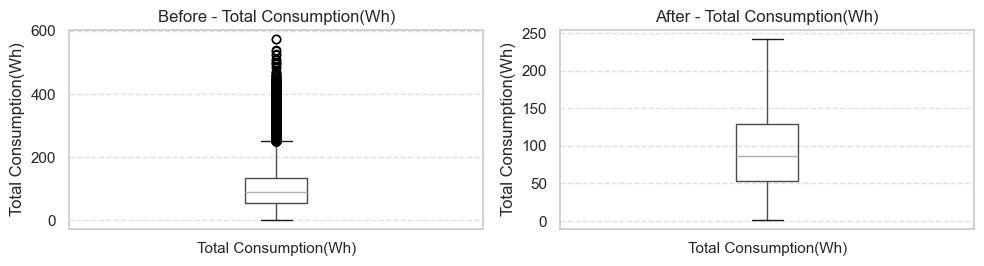

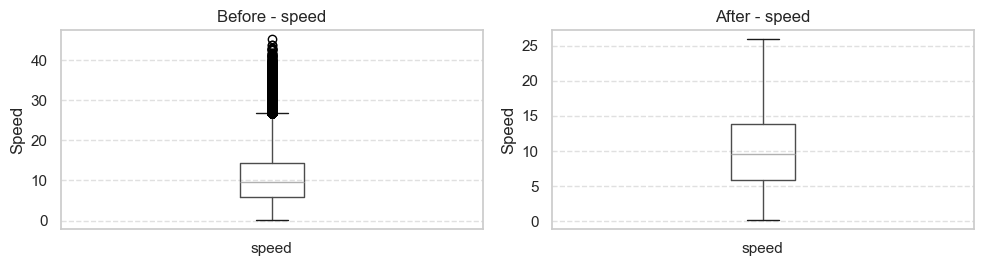

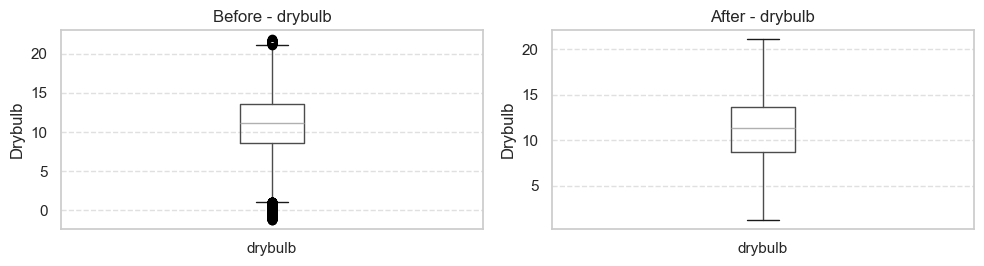

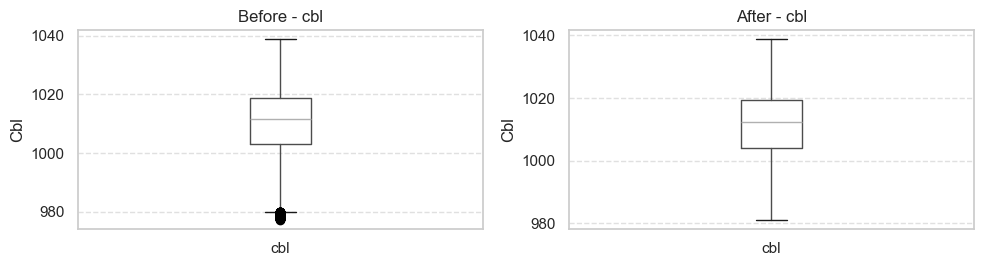

In [292]:
def compare_boxplots_custom(df, combined_df, columns, by=None):
    for col in columns:
        fig, axes = plt.subplots(1, 2, figsize=(10, 3))
        # Before
        df.boxplot(column=col, by=by, ax=axes[0])
        axes[0].set_title(f'Before - {col}')
        axes[0].set_ylabel(col.title())
        if by:
            axes[0].set_xlabel(by.title())
        axes[0].grid(axis='x')

        # After
        combined_df.boxplot(column=col, by=by, ax=axes[1])
        axes[1].set_title(f'After - {col}')
        axes[1].set_ylabel(col.title())
        if by:
            axes[1].set_xlabel(by.title())
        axes[1].grid(axis='x')

        plt.suptitle('')
        plt.tight_layout() # avoid title superposition
        plt.show()
        
compare_boxplots_custom(df, combined_df, df_cols)

### Exploratory Data Analysis 

In [293]:
# Descriptive statistics grouped by each condition
print("\nStatistical Summary:")
print(combined_df.describe())


Statistical Summary:
                                date  Total Production (Wh)  \
count                         196665          196665.000000   
mean   2020-06-20 07:31:30.703988736              25.484896   
min              2020-01-01 01:01:00               0.000000   
25%              2020-03-12 10:09:00               0.000000   
50%              2020-06-11 09:36:00               0.290000   
75%              2020-09-11 20:15:00              33.150000   
max              2020-12-12 23:59:00             276.100000   
std                              NaN              43.847866   

       Total Consumption(Wh)          speed            dir        drybulb  \
count          196665.000000  196665.000000  196665.000000  196665.000000   
mean               95.808163      10.167067     205.925984      11.182727   
min                 1.650000       0.200000       0.004000       1.236000   
25%                53.970000       5.899000     147.500000       8.690000   
50%                86.590

In [294]:
# Global Avarenge
mean_prod = combined_df['Total Production (Wh)'].mean()
mean_cons = combined_df['Total Consumption(Wh)'].mean()
print(f"Mean production: {mean_prod:.2f}, Mean consumption: {mean_cons:.2f}")

Mean production: 25.48, Mean consumption: 95.81


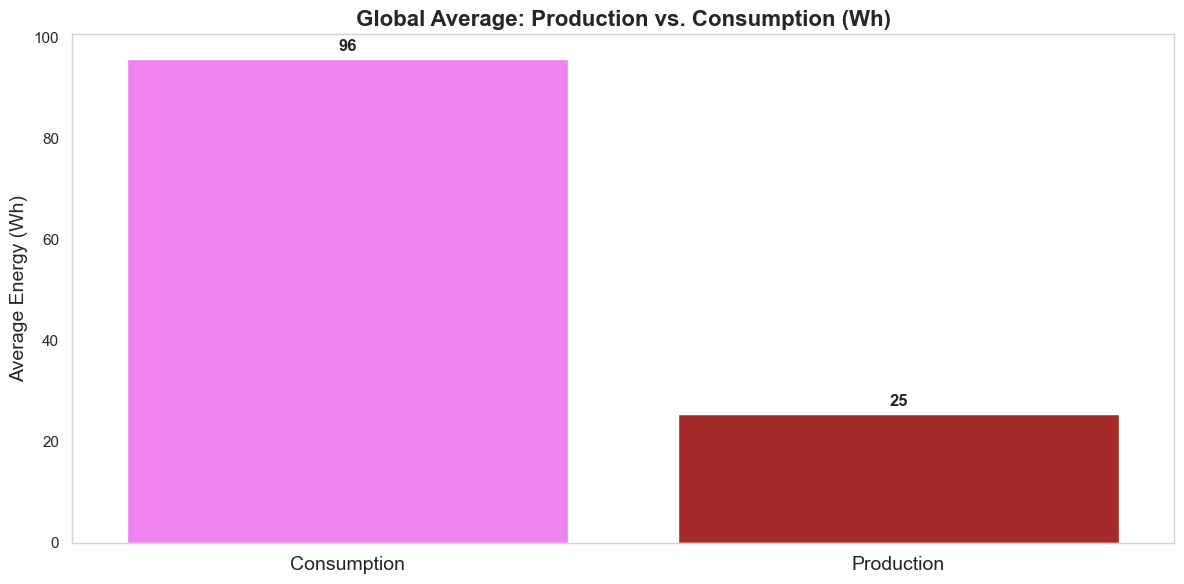

In [295]:
# Labels and values
labels = ['Consumption', 'Production']
values = [mean_cons, mean_prod]

# Positions on x-axis
x = [0, 1]

# Create figure and axis
fig, ax = plt.subplots(figsize=(12, 6), facecolor='white')
ax.set_facecolor('white')

# Draw bars
bars = ax.bar(
    x,
    values,
    color=['violet', 'brown'],
    edgecolor='white',
    linewidth=1.0
)

# Annotate values
for i, bar in enumerate(bars):
    h = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width() / 2,
        h + max(values) * 0.01,
        f'{h:.0f}',
        ha='center', va='bottom',
        fontsize=12, weight='bold'
    )

# Titles and labels
ax.set_title('Global Average: Production vs. Consumption (Wh)', fontsize=16, weight='bold')
ax.set_ylabel('Average Energy (Wh)', fontsize=14)

# Format x-axis labels
ax.set_xticks(x)
ax.set_xticklabels(labels, fontsize=14)

# Add margin on both sides of the bars
ax.set_xlim(-0.5, 1.5)  # margem lateral adicionada

# Light gray border
for spine in ax.spines.values():
    spine.set_linewidth(1)
    spine.set_edgecolor('lightgray')

# No grid
ax.grid(False)
ax.xaxis.grid(False)
ax.yaxis.grid(False)

# Layout and export
plt.tight_layout()
plt.savefig('bar_prod_vs_cons_standard.png', dpi=300, bbox_inches='tight')
plt.show()

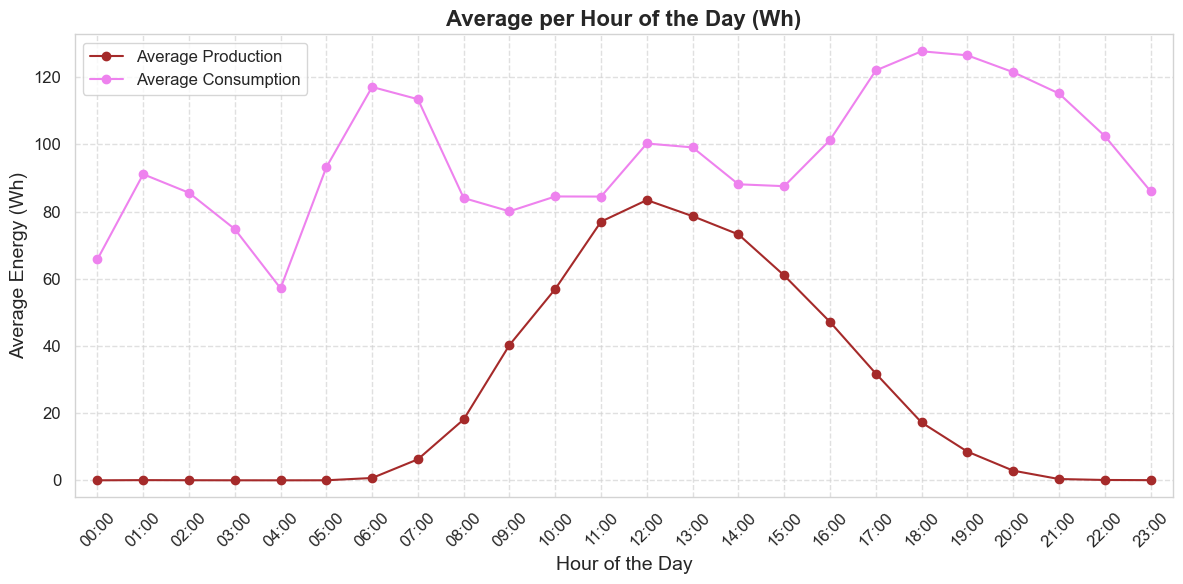

In [296]:

hourly_mean = combined_df.groupby('Hour')[['Total Production (Wh)', 'Total Consumption(Wh)']].mean()


fig, ax = plt.subplots(figsize=(12, 6))


ax.plot(hourly_mean.index,
        hourly_mean['Total Production (Wh)'],
        marker='o',
        color='brown',
        label='Average Production')

ax.plot(hourly_mean.index,
        hourly_mean['Total Consumption(Wh)'],
        marker='o',
        color='violet',
        label='Average Consumption')


ax.set_title('Average per Hour of the Day (Wh)', fontsize=16, weight='bold')
ax.set_xlabel('Hour of the Day', fontsize=14)
ax.set_ylabel('Average Energy (Wh)', fontsize=14)


def hour_format(x, pos):
    return f'{int(x):02d}:00'
ax.xaxis.set_major_formatter(FuncFormatter(hour_format))
ax.set_xticks(hourly_mean.index)
ax.tick_params(axis='x', rotation=45, labelsize=12)
ax.tick_params(axis='y', labelsize=12)


y_min = min(hourly_mean['Total Production (Wh)'].min(), hourly_mean['Total Consumption(Wh)'].min())
y_max = max(hourly_mean['Total Production (Wh)'].max(), hourly_mean['Total Consumption(Wh)'].max())
ax.set_ylim(bottom=y_min - 5, top=y_max + 5)

x_min = hourly_mean.index.min()
x_max = hourly_mean.index.max()
ax.set_xlim(left=x_min - 0.5, right=x_max + 0.5)


for spine in ax.spines.values():
    spine.set_linewidth(1)
    spine.set_edgecolor('lightgray')


ax.grid(True, linestyle='--', alpha=0.7)
ax.legend(fontsize=12, loc='upper left')


plt.tight_layout()
plt.savefig('average_per_hour.png', dpi=300, bbox_inches='tight')
plt.show()

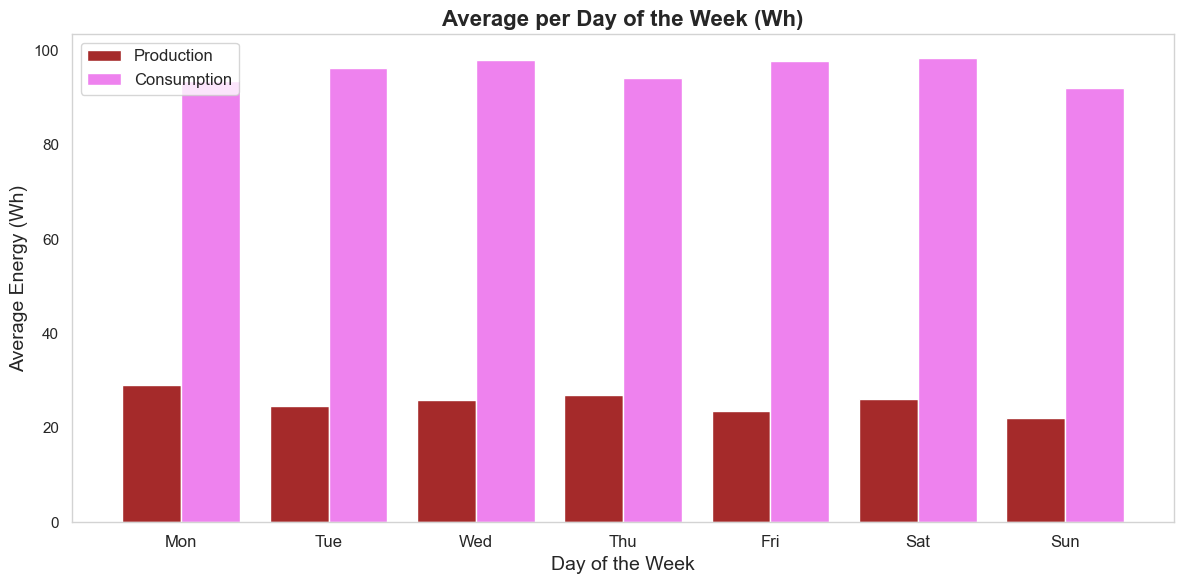

In [297]:
import matplotlib.pyplot as plt
import numpy as np


weekly_mean = combined_df.groupby('Day_of_Week')[['Total Production (Wh)', 'Total Consumption(Wh)']].mean()
weekly_mean = weekly_mean.sort_index()


bar_width = 0.4
x = np.arange(len(weekly_mean))


fig, ax = plt.subplots(figsize=(12, 6))


ax.bar(x - bar_width/2, weekly_mean['Total Production (Wh)'],
       width=bar_width, label='Production', color='brown')

ax.bar(x + bar_width/2, weekly_mean['Total Consumption(Wh)'],
       width=bar_width, label='Consumption', color='violet')

ax.set_title('Average per Day of the Week (Wh)', fontsize=16, weight='bold')
ax.set_xlabel('Day of the Week', fontsize=14)
ax.set_ylabel('Average Energy (Wh)', fontsize=14)


weekday_labels = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
ax.set_xticks(x)
ax.set_xticklabels(weekday_labels, fontsize=12)


ax.grid(False)

for spine in ax.spines.values():
    spine.set_linewidth(1)
    spine.set_edgecolor('lightgray')

ax.legend(fontsize=12, loc='upper left')


plt.tight_layout()
plt.savefig('average_per_weekday.png', dpi=300, bbox_inches='tight')
plt.show()

            Total Production (Wh)  Total Consumption(Wh)
Date                                                    
2020-01-01               6.644448             108.308958
2020-01-02              10.113448              98.063224
2020-01-03              36.124798             111.547753
2020-01-04              38.394439             103.593796
2020-01-05              30.025257              33.934115


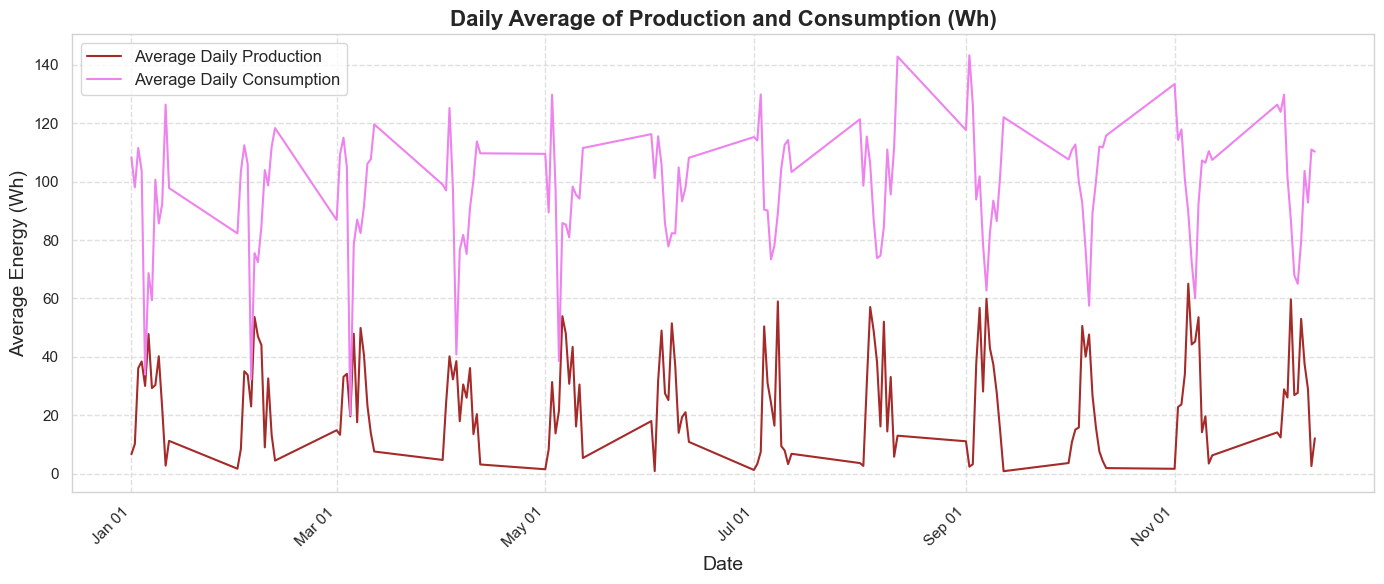

In [298]:
import matplotlib.dates as mdates


daily_mean = combined_df.groupby('Date')[['Total Production (Wh)', 'Total Consumption(Wh)']].mean()

print(daily_mean.head())


fig, ax = plt.subplots(figsize=(14, 6))


ax.plot(daily_mean.index, daily_mean['Total Production (Wh)'],
        label='Average Daily Production',
        color='brown')

ax.plot(daily_mean.index, daily_mean['Total Consumption(Wh)'],
        label='Average Daily Consumption',
        color='violet')


ax.set_title('Daily Average of Production and Consumption (Wh)', fontsize=16, weight='bold')
ax.set_xlabel("Date", fontsize=14)
ax.set_ylabel("Average Energy (Wh)", fontsize=14)


ax.xaxis.set_major_locator(mdates.AutoDateLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))  # ex: Jan 01
plt.setp(ax.get_xticklabels(), rotation=45, ha='right', fontsize=11)


ax.grid(True, linestyle='--', alpha=0.7)

for spine in ax.spines.values():
    spine.set_linewidth(1)
    spine.set_edgecolor('lightgray')


ax.legend(fontsize=12, loc='upper left')


plt.tight_layout()
plt.savefig('daily_energy_production_consumption.png', dpi=300, bbox_inches='tight')
plt.show()

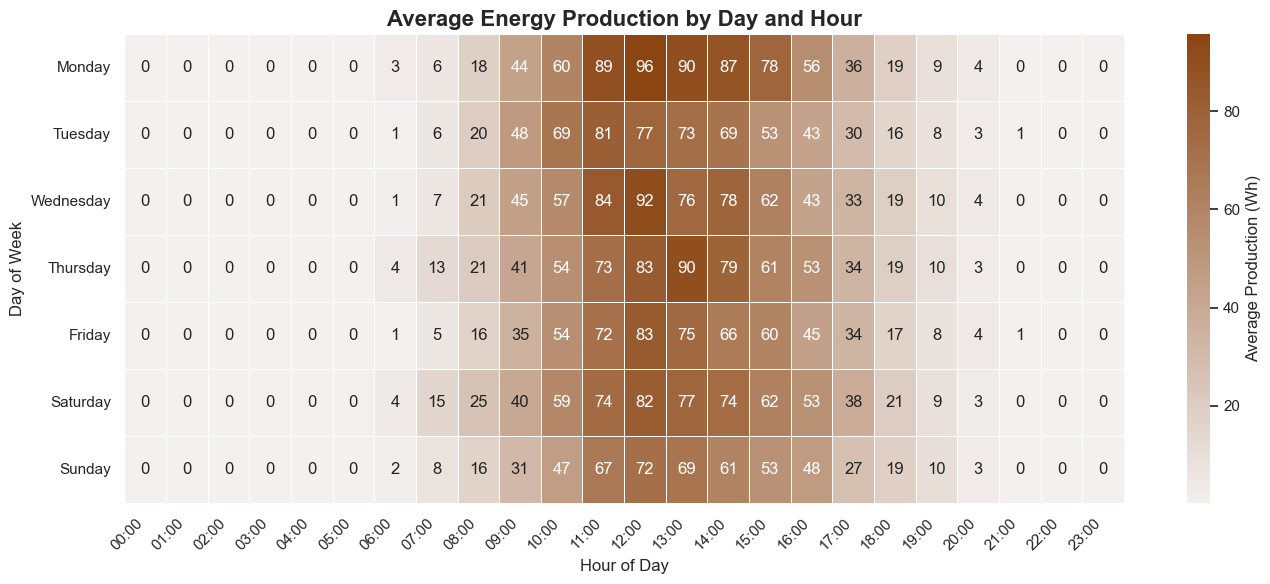

In [299]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter


brown_cmap = sns.light_palette("saddlebrown", n_colors=256, reverse=False, as_cmap=True)


def hour_format(x, pos):
    return f"{int(x):02d}:00"


fig, ax = plt.subplots(figsize=(14,6))
sns.heatmap(
    pivot,
    annot=True,
    fmt=".0f",
    cmap=brown_cmap,                     # ← nova paleta
    cbar_kws={'label':'Average Production (Wh)'},
    linewidths=0.5,
    linecolor='white',
    ax=ax
)


ax.xaxis.set_major_formatter(FuncFormatter(hour_format))


ax.set_xlabel('Hour of Day', fontsize=12)
ax.set_ylabel('Day of Week', fontsize=12)
ax.set_title('Average Energy Production by Day and Hour', fontsize=16, weight='bold')
plt.yticks(rotation=0)
plt.xticks(rotation=45, ha='right')

# Layout final
plt.tight_layout()
plt.savefig('avarage_energy_production.png', dpi=300, bbox_inches='tight')
plt.show()


/var/folders/xj/vmtsvzgs6zj1l876xt4q0nkw0000gn/T/ipykernel_83995/2347317295.py:16: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='Temp_Q', y='Total Production (Wh)',
/var/folders/xj/vmtsvzgs6zj1l876xt4q0nkw0000gn/T/ipykernel_83995/2347317295.py:21: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='Sol_Q', y='Total Production (Wh)',
/var/folders/xj/vmtsvzgs6zj1l876xt4q0nkw0000gn/T/ipykernel_83995/2347317295.py:26: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='Wind_Q', y='Total Production (Wh)',
/var/folders/xj/vmtsvzgs6zj1l876xt4q0nkw0000gn/T/ipykernel_83995/2347317295.py:31: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='Rain_Flag', y='Total Production (Wh)',


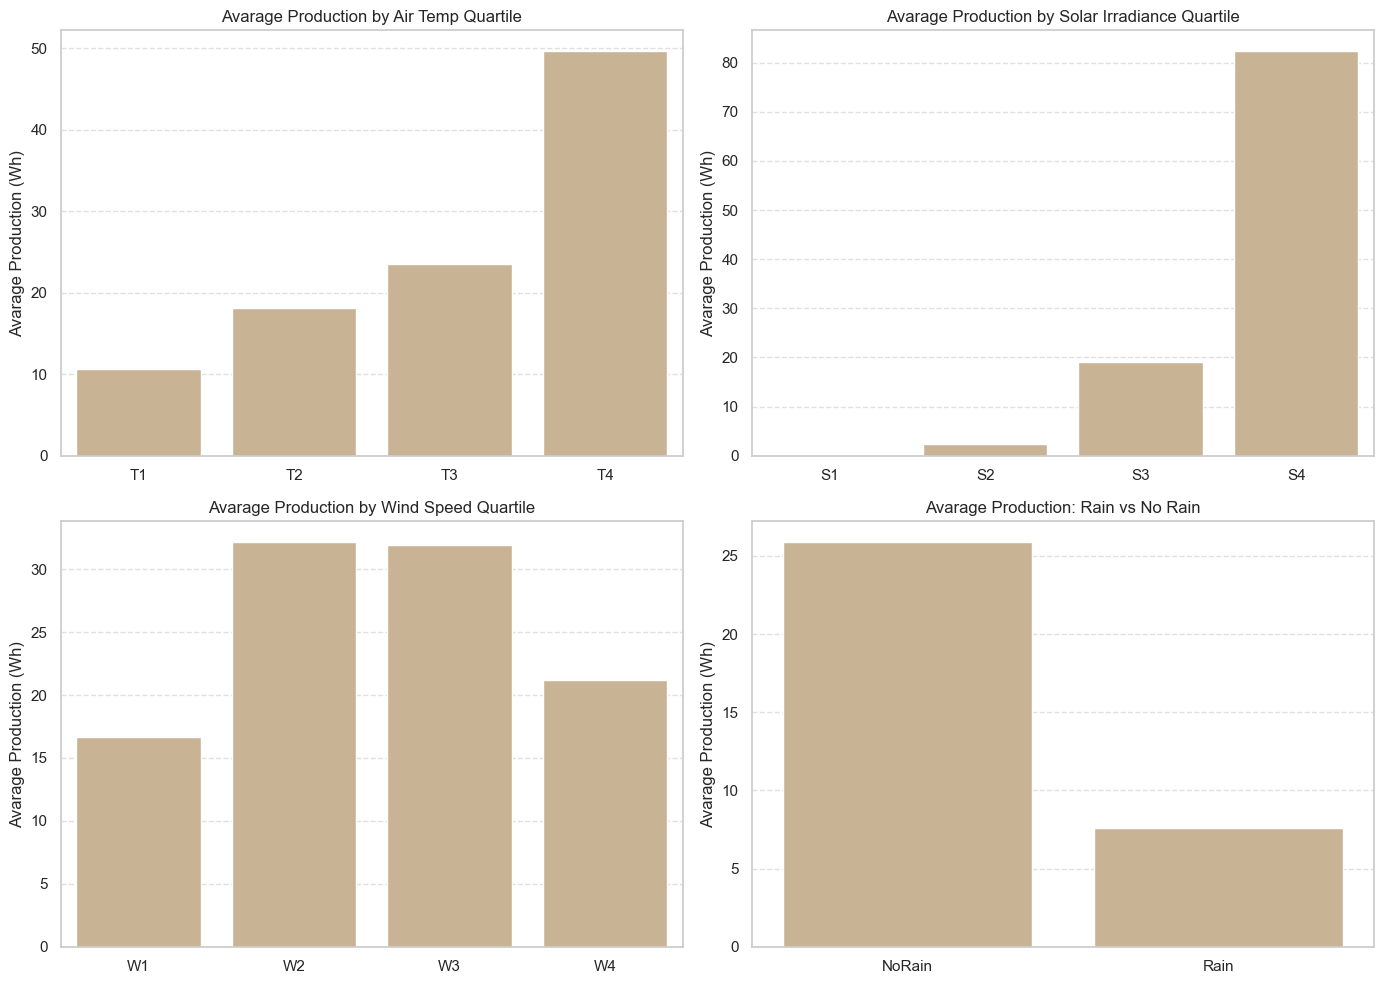

Temperature quartiles (drybulb):
  T1: 1.24 – 8.69 °C
  T2: 8.69 – 11.29 °C
  T3: 11.29 – 13.66 °C
  T4: 13.66 – 21.07 °C

Solar irradiance quartiles (soltot):
  S1: -98.80 – 0.00 W/m²
  S2: 0.00 – 0.02 W/m²
  S3: 0.02 – 0.85 W/m²
  S4: 0.85 – 7.89 W/m²

Wind speed quartiles (speed):
  W1: 0.20 – 5.90 m/s
  W2: 5.90 – 9.58 m/s
  W3: 9.58 – 13.90 m/s
  W4: 13.90 – 25.90 m/s


In [300]:

df = combined_df.copy()


df['Temp_Q']    = pd.qcut(df['drybulb'], q=4, labels=['T1','T2','T3','T4'])
df['Sol_Q']     = pd.qcut(df['soltot'],  q=4, labels=['S1','S2','S3','S4'])
df['Wind_Q']    = pd.qcut(df['speed'],   q=4, labels=['W1','W2','W3','W4'])
df['Rain_Flag'] = pd.cut(df['rain'], bins=[-1, 0, df['rain'].max()],
                        labels=['NoRain', 'Rain'])


fig, axes = plt.subplots(2, 2, figsize=(14, 10))
light_brown = "#D2B48C"  


sns.barplot(x='Temp_Q', y='Total Production (Wh)',
            data=df, ax=axes[0,0],
            color=light_brown, ci=None)
axes[0,0].set_title('Avarage Production by Air Temp Quartile')

sns.barplot(x='Sol_Q', y='Total Production (Wh)',
            data=df, ax=axes[0,1],
            color=light_brown, ci=None)
axes[0,1].set_title('Avarage Production by Solar Irradiance Quartile')

sns.barplot(x='Wind_Q', y='Total Production (Wh)',
            data=df, ax=axes[1,0],
            color=light_brown, ci=None)
axes[1,0].set_title('Avarage Production by Wind Speed Quartile')

sns.barplot(x='Rain_Flag', y='Total Production (Wh)',
            data=df, ax=axes[1,1],
            color=light_brown, ci=None)
axes[1,1].set_title('Avarage Production: Rain vs No Rain')


for ax in axes.flatten():
    ax.set_xlabel('')
    ax.set_ylabel('Avarage Production (Wh)')


plt.tight_layout()
plt.savefig('mean_energy_production_by_weather.png', dpi=300, bbox_inches='tight')
plt.show()


temp_bins = pd.qcut(combined_df['drybulb'], q=4)    # sem labels
sol_bins  = pd.qcut(combined_df['soltot'],  q=4)
wind_bins = pd.qcut(combined_df['speed'],   q=4)

temp_intervals = temp_bins.cat.categories
sol_intervals  = sol_bins.cat.categories
wind_intervals = wind_bins.cat.categories


temp_labels = ['T1','T2','T3','T4']
sol_labels  = ['S1','S2','S3','S4']
wind_labels = ['W1','W2','W3','W4']


print("Temperature quartiles (drybulb):")
for label, iv in zip(temp_labels, temp_intervals):
    print(f"  {label}: {iv.left:.2f} – {iv.right:.2f} °C")

print("\nSolar irradiance quartiles (soltot):")
for label, iv in zip(sol_labels, sol_intervals):
    print(f"  {label}: {iv.left:.2f} – {iv.right:.2f} W/m²")

print("\nWind speed quartiles (speed):")
for label, iv in zip(wind_labels, wind_intervals):
    print(f"  {label}: {iv.left:.2f} – {iv.right:.2f} m/s")

In [301]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

# Restore matplotlib’s true factory defaults
mpl.rcParams.update(mpl.rcParamsDefault)

# Tell Seaborn to use a white background (no grey)
sns.set_theme(style='whitegrid', rc={
    'figure.facecolor': 'white',   # figure background
    'axes.facecolor'  : 'white',   # plotting area
    'grid.color'      : 'lightgray',
    'grid.linestyle'  : '--',
    'grid.alpha'      : 0.7,
})



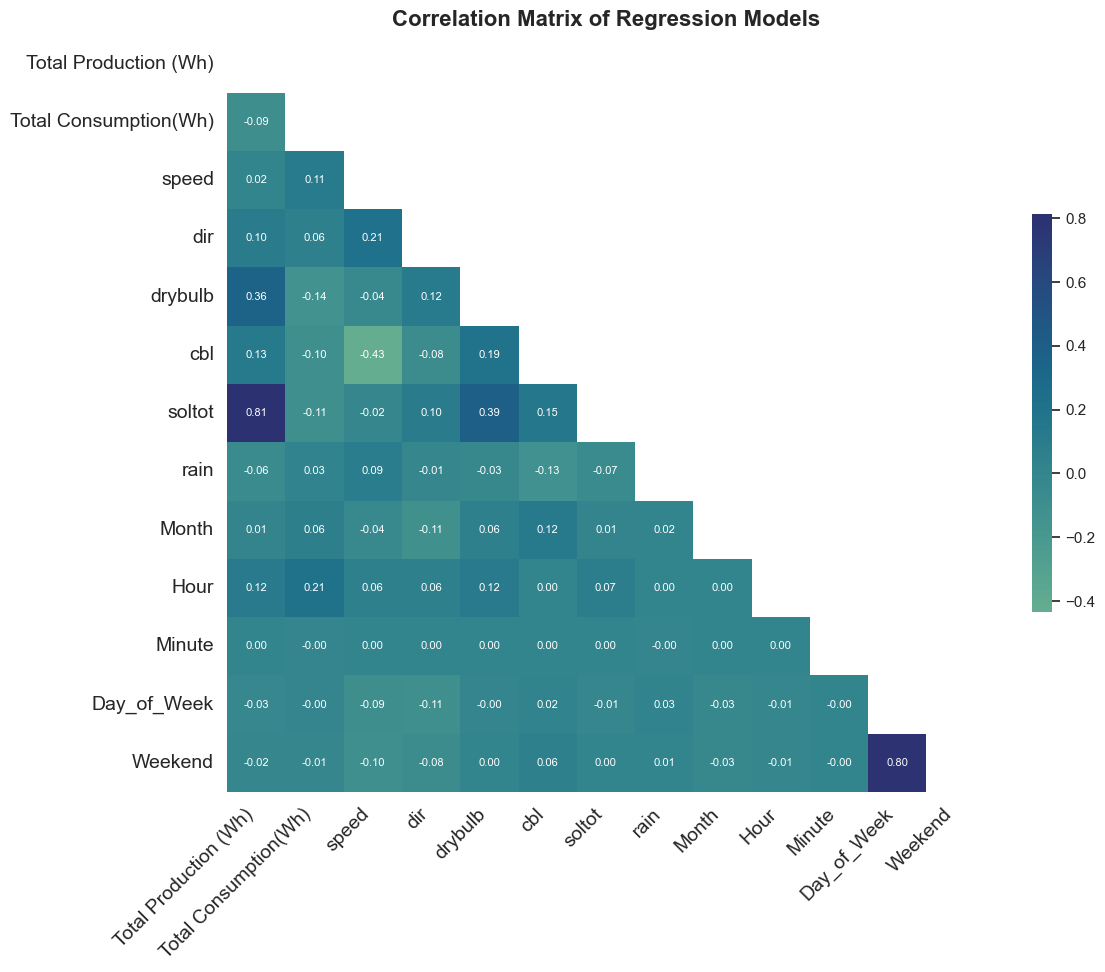

In [302]:
# Select numeric columns with nonzero variance
num_cols   = df.select_dtypes(include='number').columns
variables  = df[num_cols].loc[:, df[num_cols].std() != 0]
corr_matrix = variables.corr()

# Build the mask for the upper triangle
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# Draw the heatmap
plt.figure(figsize=(12, 10))
ax = sns.heatmap(
    corr_matrix,
    mask=mask,
    cmap="crest",           # your preferred palette
    center=0,
    annot=True,
    fmt=".2f",
    annot_kws={"size": 8},
    linewidths=0,           # no separation lines
    cbar_kws={"shrink": 0.5},
    square=True,
    xticklabels=True,
    yticklabels=True
)

# Remove any remaining grid or cell‐edge lines
ax.grid(False)                     # turn off the axes grid
# remove the default border
for spine in ax.spines.values():
    spine.set_visible(False)
# ensure that patches have no visible edge
if ax.collections:
    ax.collections[0].set_edgecolor("face")

# Tidy up the ticks and title
plt.xticks(rotation=45, ha='right', fontsize=14)
plt.yticks(rotation=0, fontsize=14)
plt.title("Correlation Matrix of Regression Models", fontsize=16, weight='bold')
plt.tight_layout()
plt.savefig('correlation_ie.png', dpi=300)
plt.show()

`Training model`

In [303]:
from sklearn.preprocessing import StandardScaler

combined_df = combined_df.copy()

features_prod = ['speed','dir','soltot','drybulb', 'rain', 'Month','Hour']

X = combined_df[features_prod]
y = combined_df['Total Production (Wh)']

# Split data into training and testing sets
train_size = int(0.8 * len(X))
X_train, X_test = X.iloc[:train_size], X.iloc[train_size:]
y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]


# scaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

`Model 1: Regression Tree`

Best hyperparameters found: {'max_depth': 12, 'max_features': None, 'min_samples_leaf': 9, 'min_samples_split': 6}
Mean RMSE: 26.10 Wh

Decision Tree Regressor performance on test set:
R²   = 0.585
MAE  = 13.30 Wh
RMSE = 28.45 Wh


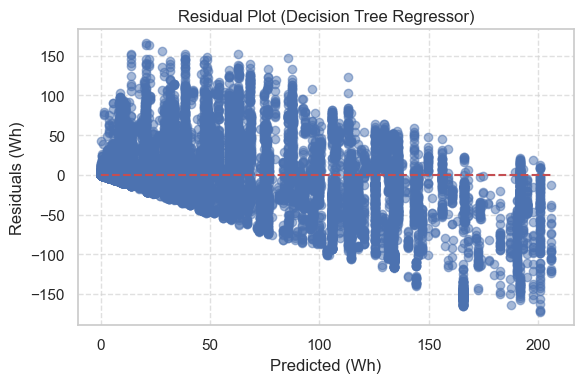

In [304]:
# Define distributions for RandomizedSearchCV
param_dist_tree = {
    'max_depth':         randint(5, 50),
    'min_samples_split': randint(2, 20),
    'min_samples_leaf':  randint(1, 10),
    'max_features':      ['sqrt', 'log2', None]
}

# Configure time-series cross‐validation
tscv = TimeSeriesSplit(n_splits=5)

# Instantiate RandomizedSearchCV
rand_search = RandomizedSearchCV(
    DecisionTreeRegressor(random_state=42),
    param_distributions=param_dist_tree,
    n_iter=40,
    cv=tscv,
    scoring='neg_mean_squared_error',
    random_state=42,
    n_jobs=-1
)

# Fit on the scaled training set
rand_search.fit(X_train_scaled, y_train)
y_pred_tree = rand_search.predict(X_test_scaled)

# Extract best parameters and CV RMSE
best_params = rand_search.best_params_
best_rmse   = np.sqrt(-rand_search.best_score_)
print("Best hyperparameters found:", best_params)
print(f"Mean RMSE: {best_rmse:.2f} Wh")

# Re-train DecisionTreeRegressor with optimal parameters
best_tree = DecisionTreeRegressor(random_state=42, **best_params)
best_tree.fit(X_train_scaled, y_train)

# Evaluate on the test set
r2    = r2_score(y_test, y_pred_tree)
mae   = mean_absolute_error(y_test, y_pred_tree)
rmse  = np.sqrt(mean_squared_error(y_test, y_pred_tree))

print(f"\nDecision Tree Regressor performance on test set:")
print(f"R²   = {r2:.3f}")
print(f"MAE  = {mae:.2f} Wh")
print(f"RMSE = {rmse:.2f} Wh")

# Residual plot
residuals = y_test - y_pred_tree
plt.figure(figsize=(6,4))
plt.scatter(y_pred_tree, residuals, alpha=0.5)
plt.hlines(0, xmin=y_pred_tree.min(), xmax=y_pred_tree.max(), colors='r', linestyles='--')

plt.xlabel("Predicted (Wh)")
plt.ylabel("Residuals (Wh)")
plt.title("Residual Plot (Decision Tree Regressor)")
plt.grid(True)
plt.tight_layout()
plt.savefig('residual_decision_tree_reg.png', dpi=300)
plt.show()

In [305]:
importances = best_tree.feature_importances_
pd.Series(importances, index=X.columns).sort_values().plot(kind='barh')

<Axes: >

Starting RandomizedSearchCV for KNN
Best k found: 29

KNN Test Set Performance:
R²   = 0.634
MAE  = 14.00 Wh
RMSE = 26.74 Wh


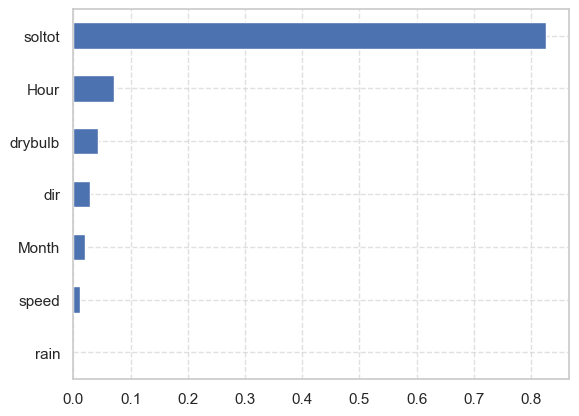

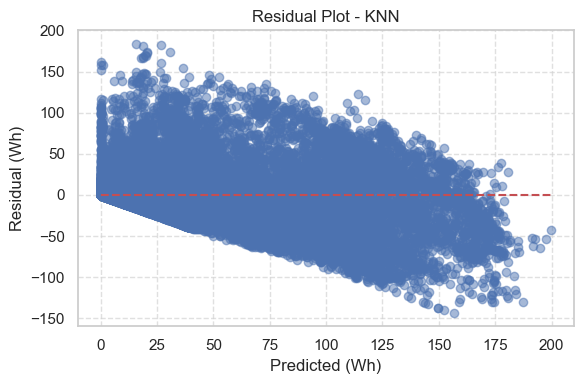

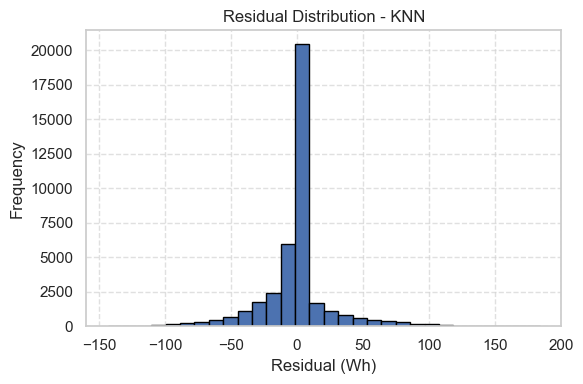

In [ ]:
# --- Hyperparameter tuning configuration ---
param_dist_knn = {'n_neighbors': randint(1, 30)}
tscv = TimeSeriesSplit(n_splits=3)

print("Starting RandomizedSearchCV for KNN")

knn_search = RandomizedSearchCV(
    KNeighborsRegressor(),
    param_distributions=param_dist_knn,
    n_iter=30,
    cv=tscv,
    scoring='neg_mean_squared_error',
    random_state=42,
    n_jobs=-1
)

knn_search.fit(X_train_scaled, y_train)
y_pred_knn = knn_search.predict(X_test_scaled)

# --- Tuning results ---
best_k = knn_search.best_params_['n_neighbors']
print(f"Best k found: {best_k}")

# --- Train final model with the best k ---
knn = KNeighborsRegressor(n_neighbors=best_k)
knn.fit(X_train_scaled, y_train)

# --- Predictions and evaluation ---
r2   = r2_score(y_test, y_pred_knn)
mae  = mean_absolute_error(y_test, y_pred_knn)
rmse = np.sqrt(mean_squared_error(y_test, y_pred_knn))

print(f"\nKNN Test Set Performance:")
print(f"R²   = {r2:.3f}")
print(f"MAE  = {mae:.2f} Wh")
print(f"RMSE = {rmse:.2f} Wh")

# --- Residual plot ---
residuals = y_test - y_pred_knn
plt.figure(figsize=(6, 4))
plt.scatter(y_pred_knn, residuals, alpha=0.5)
plt.hlines(0, xmin=y_pred_knn.min(), xmax=y_pred_knn.max(),
           colors='r', linestyles='--')
plt.xlabel("Predicted (Wh)")
plt.ylabel("Residual (Wh)")
plt.title("Residual Plot - KNN")
plt.grid(True)
plt.tight_layout()
plt.savefig('residual_knn.png', dpi=300)
plt.show()

# --- Residual histogram ---
plt.figure(figsize=(6, 4))
plt.hist(residuals, bins=30, edgecolor='black')
plt.title("Residual Distribution - KNN")
plt.xlabel("Residual (Wh)")
plt.ylabel("Frequency")
plt.grid(True)
plt.tight_layout()
plt.savefig('residual_hist_knn.png', dpi=300)
plt.show()


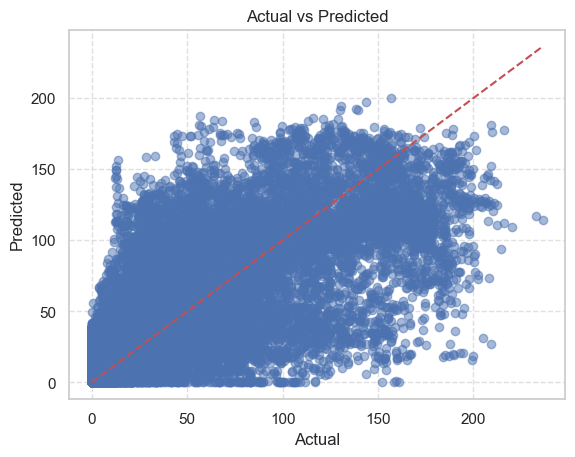

In [307]:
plt.scatter(y_test, y_pred_knn, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted')
plt.show()


`Comparison`

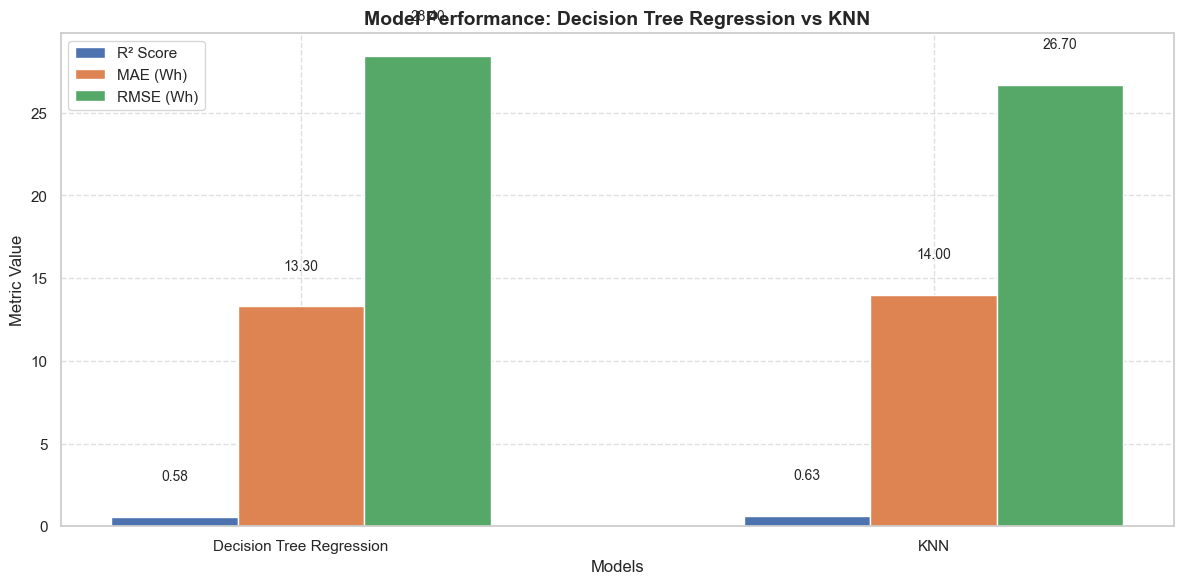

In [311]:
# Metric values
model_names = ['Decision Tree Regression', 'KNN']
r2_scores = [0.58, 0.63]
mae_scores = [13.3, 14.0]
rmse_scores = [28.4, 26.7]

x = np.arange(len(model_names))
width = 0.2

fig, ax = plt.subplots(figsize=(12, 6))

# Plot bars
bar_r2 = ax.bar(x - width, r2_scores, width, label='R² Score')
bar_mae = ax.bar(x, mae_scores, width, label='MAE (Wh)')
bar_rmse = ax.bar(x + width, rmse_scores, width, label='RMSE (Wh)')

# Add text labels on top of bars
for bars in [bar_r2, bar_mae, bar_rmse]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2, height + 2, f'{height:.2f}',
                ha='center', va='bottom', fontsize=10)

# Labels and formatting
ax.set_xlabel('Models', fontsize=12)
ax.set_ylabel('Metric Value', fontsize=12)
ax.set_title('Model Performance: Decision Tree Regression vs KNN', fontsize=14, weight='bold')
ax.set_xticks(x)
ax.set_xticklabels(model_names)
ax.legend()

plt.tight_layout()
plt.savefig('model_performance', dpi=300)
plt.show()